In [17]:
%matplotlib notebook

import datetime
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 4.0)

import load_hats

start_day, end_day = '2016-06-01', '2018-05-31'

In [2]:
def read_met(site, yyyy):
    met_ftp = f'/aftp/met/{site}/'
    met_file = f'met_{site}_insitu_1_obop_hour_{yyyy}.txt'
    df = pd.read_csv(met_ftp+met_file, 
                delim_whitespace=True,
                names=['site','year','month','day','hour','wind_dir','wind_speed','wind_steady','press','temp2','temp10','jj','jk','jl'],
                parse_dates = {'date':[1,2,3,4]},
                infer_datetime_format=True,
                index_col='date',
                na_values=['-999.9', '-999', '-99']
                )
    df.drop(['temp2','temp10','jj','jk','jl'], axis=1, inplace=True)
    return df

<h1>Load NOAA met data

In [3]:
dfs = []
for y in [2016, 2017, 2018]:
    df = read_met('mlo', y)
    dfs.append(df)
met = pd.concat(dfs, axis=0)
met = met[start_day:end_day]

In [4]:
met.head()

,site,wind_dir,wind_speed,wind_steady,press
date,,,,,
2016-06-01 00:00:00,MLO,339.0,3.0,93,679.55
2016-06-01 01:00:00,MLO,3.0,2.7,93,679.24
2016-06-01 02:00:00,MLO,332.0,3.2,96,679.16
2016-06-01 03:00:00,MLO,344.0,1.9,95,679.23
2016-06-01 04:00:00,MLO,37.0,1.4,94,679.56


<h1>Load CATS data

In [5]:
cats = load_hats.CATS_FTP()
mlo = cats.hourly('f11', 'mlo')
mlo = mlo[start_day:end_day].dropna()

In [6]:
mlo.head()

,mlo_mr,mlo_sd
date,,
2016-06-01 01:42:00,230.413,0.356
2016-06-01 02:42:00,230.431,0.356
2016-06-01 03:42:00,230.488,0.355
2016-06-01 04:42:00,229.782,0.355
2016-06-01 05:42:00,229.645,0.358


<h2>Merge dataframes and interpolate wind speed and direction

In [7]:
full = pd.concat([mlo, met], axis=1)
full['wind_dir'] = full.wind_dir.interpolate()
full['wind_speed'] = full.wind_speed.interpolate()
full = full.drop(['site', 'wind_steady', 'press'], axis=1).dropna()
full.head()

,mlo_mr,mlo_sd,wind_dir,wind_speed
date,,,,
2016-06-01 01:42:00,230.413,0.356,167.5,2.95
2016-06-01 02:42:00,230.431,0.356,338.0,2.55
2016-06-01 03:42:00,230.488,0.355,190.5,1.65
2016-06-01 04:42:00,229.782,0.355,164.0,1.15
2016-06-01 05:42:00,229.645,0.358,283.0,2.15


<h2>Identify local day and night samples

In [8]:
full = full.reset_index()
full = full.assign(local=(full.date.dt.tz_localize('utc').dt.tz_convert('US/Hawaii')))
full = full.set_index(full.date)

In [9]:
full = full.assign(night=((full.local.dt.hour >= 22)|(full.local.dt.hour <= 8))&(full.wind_dir<=250)&(full.wind_dir>=110))
full = full.assign(day=(full.local.dt.hour >= 10)&(full.local.dt.hour <= 20))

<IPython.core.display.Javascript object>


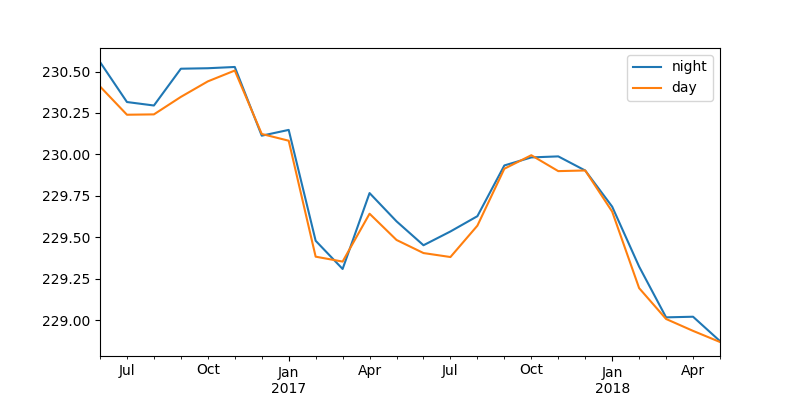

In [18]:
full.loc[full.night==True].mlo_mr.resample('M').mean().plot(label='night')
full.loc[full.day==True].mlo_mr.resample('M').mean().plot(label='day')
plt.legend()

<IPython.core.display.Javascript object>


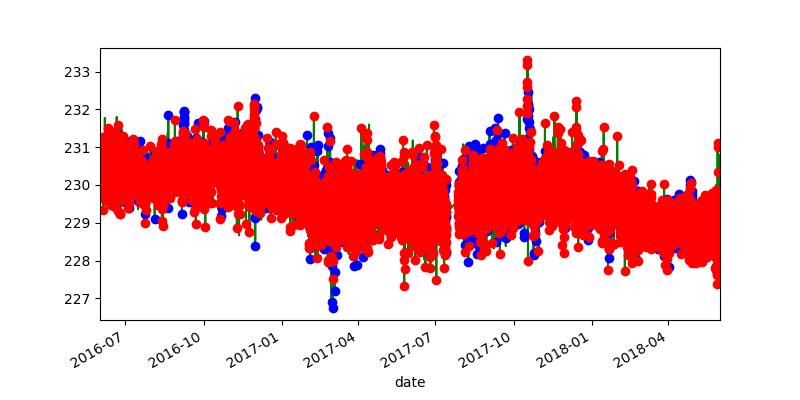

In [19]:
full.mlo_mr.plot(color='g')
full.loc[full.night==True].mlo_mr.plot(marker='o', linestyle='None', color='b')
full.loc[full.day==True].mlo_mr.plot(marker='o', linestyle='None', color='r')

<h2>Select daily night time sample

In [26]:
#clean = full.assign(week=(full.local.dt.weekday_name == 'Saturday'))
#clean = clean.loc[(clean.week==True)&(clean.night==True)]
#clean = full.loc[full.night==True]
clean = full.loc[(full.local.dt.hour==3)|(full.local.dt.hour==4)]
# if more than one data point per week, select the first
clean = clean.assign(dd=clean.date.diff()>datetime.timedelta(0,4*3600))
clean = clean.loc[clean.dd==True]
clean.drop(['date','night','day','dd'], axis=1, inplace=True)

In [27]:
clean.head()

,mlo_mr,mlo_sd,wind_dir,wind_speed,local
date,,,,,
2016-06-02 13:44:00,230.468,0.421,216.5,3.70,2016-06-02 03:44:00-10:00
2016-06-03 13:46:00,231.089,0.409,232.5,3.70,2016-06-03 03:46:00-10:00
2016-06-04 13:48:00,230.452,0.400,236.0,3.80,2016-06-04 03:48:00-10:00
2016-06-05 13:49:00,230.200,0.431,255.0,6.90,2016-06-05 03:49:00-10:00
2016-06-06 13:51:00,230.486,0.428,250.0,2.75,2016-06-06 03:51:00-10:00


<IPython.core.display.Javascript object>


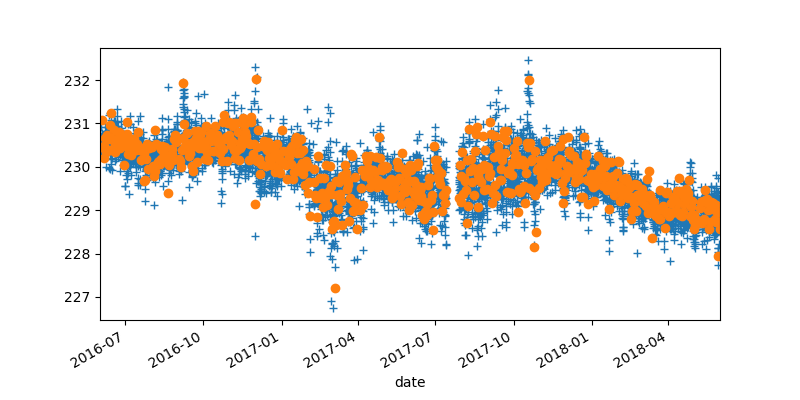

In [29]:
full.loc[full.night==True].mlo_mr.plot(marker='+', linestyle='None')
clean.mlo_mr.plot(marker='o', linestyle='None')

In [30]:
print(f"Number of measurements full:{full.shape[0]} clean:{clean.shape[0]}")

Number of measurements full:16074 clean:700


In [32]:
clean.to_csv('mlo-clean.csv')
full.loc[full.night==True].to_csv('mlo-night.csv')